# Using rf_functions module to compute rf buckets properties

In [1]:
# Adding folder on TOP of blond_common to PYTHONPATH
import sys
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
sys.path.append('./../../../')

## 0. Defining base ring and rf parameters

In [2]:
# Defining a ramp with a program time vs. energy (warning: initial energy cannot be 0)
# Based on PS with Xe39+ ions at flat top

from blond_common_fork.interfaces.beam.beam import Particle
from blond_common_fork.interfaces.input_parameters.ring import Ring
from scipy.constants import u,c,e

ring_length = 2*np.pi*100                   # Machine circumference [m]
bending_radius = 70.079                     # Bending radius [m]
bending_field = 1.136487                    # Bending field [T]
gamma_transition = 6.1                      # Transition gamma
alpha_0 = 1/gamma_transition**2.

particle_charge = 39                            # Particle charge [e]
particle_mass = 128.883*u*c**2./e               # Particle mass [eV/c2]
particle = Particle(particle_mass, particle_charge)

ring = Ring(ring_length, alpha_0, bending_field,
            particle, synchronous_data_type='bending field',
            bending_radius=bending_radius)


In [3]:
# Defining the rf program
# The program is based on a batch compression and a rebucketting, the rf voltage at the three stages
# can be used for the example

from blond_common_fork.interfaces.input_parameters.rf_parameters import RFStation

harmonic = [21, 28, 169]
#voltage = [80e3, 0, 0]  # V, h21 start with single RF
voltage = [6e3, 20e3, 0]  # V, h21->h28 batch compression
#voltage = [0, 16.1e3, 12.4e3]  # V, h28->h169 rebucketting
phi_rf = [np.pi, np.pi, np.pi]  # rad

rf_station = RFStation(ring, harmonic, voltage, phi_rf, n_rf=3)


## 1. Computing the RF voltage and RF potential

In [4]:
# Computing the total rf voltage, using the parameters defined above
# The rf is computed on the limits defined by time_bounds

from blond_common_fork.rf_functions.potential import rf_voltage_generation

n_points = 10000
t_rev = ring.t_rev[0]
voltage = rf_station.voltage[:,0]
harmonic = rf_station.harmonic[:,0]
phi_rf = rf_station.phi_rf[:,0]
time_bounds = [-ring.t_rev[0]/harmonic[0]*2, ring.t_rev[0]/harmonic[0]*2]

time_array, rf_voltage_array = rf_voltage_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, time_bounds=time_bounds)


<IPython.core.display.Javascript object>


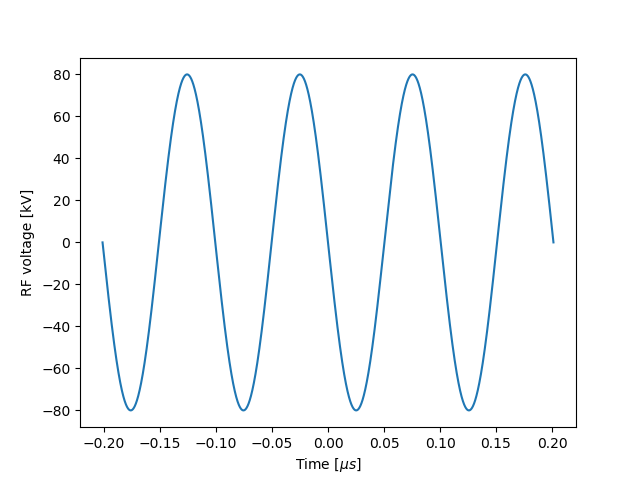

Text(0, 0.5, 'RF voltage [kV]')

In [5]:
# Plotting the total rf voltage
plt.figure('RF voltage')
plt.clf()
plt.plot(time_array*1e6, rf_voltage_array/1e3)
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF voltage [kV]')

In [6]:
# The rf potential can be calculated analytically

from blond_common_fork.rf_functions.potential import rf_potential_generation

n_points = 10000
eta_0 = ring.eta_0[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds)

<IPython.core.display.Javascript object>


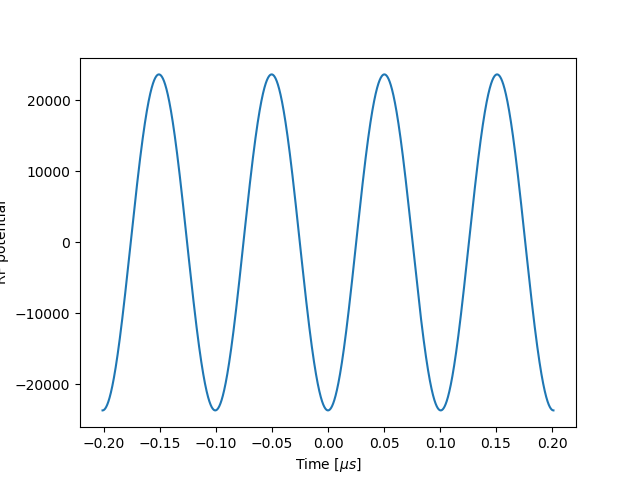

Text(0, 0.5, 'RF potential')

In [7]:
# TPlotting the rf potential

plt.figure('Potential well')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array)
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [8]:
# Here we force the acceleration by passing the energy_increment_bis to not be 0

from blond_common_fork.rf_functions.potential import rf_potential_generation

n_points = 10000
eta_0 = ring.eta_0[0,0]
charge = ring.Particle.charge
energy_increment_bis = charge*5e3

time_array, rf_potential_array_acc = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment_bis,
    time_bounds=time_bounds)

<IPython.core.display.Javascript object>


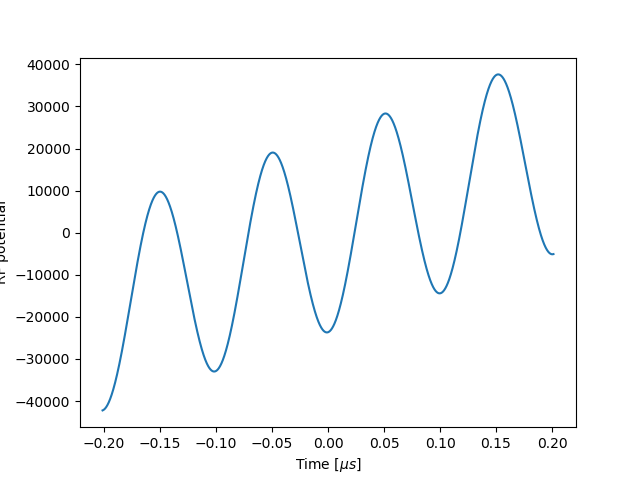

Text(0, 0.5, 'RF potential')

In [9]:
# Plotting the rf potential with acceleration

plt.figure('Potential well acc')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array_acc)
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [10]:
# The rf potential can also be obtained using cubic spline integral
# This can be useful for arbitrary rf voltage or with intensity effects

from blond_common_fork.rf_functions.potential import rf_potential_generation_cubic

time_array, rf_potential_array_cubic = rf_potential_generation_cubic(
    time_array, rf_voltage_array, eta_0, charge, t_rev, energy_increment)[0:2]


<IPython.core.display.Javascript object>


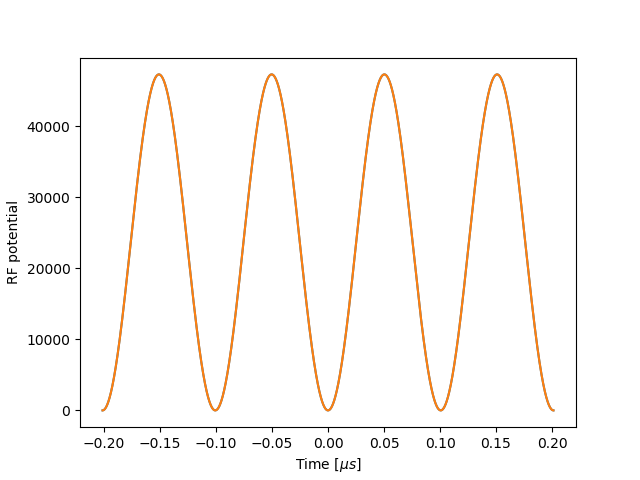

Text(0, 0.5, 'RF potential')

In [11]:
# Comparing analytical rf potential with one from cubic splint integration

plt.figure('Potential well -2')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array-np.min(rf_potential_array))
plt.plot(time_array*1e6, rf_potential_array_cubic-np.min(rf_potential_array_cubic))
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [12]:
# The same can be done for the case with acceleration

from blond_common_fork.rf_functions.potential import rf_potential_generation_cubic

time_array, rf_potential_array_cubic_acc = rf_potential_generation_cubic(
    time_array, rf_voltage_array, eta_0, charge, t_rev, energy_increment_bis)[0:2]


<IPython.core.display.Javascript object>


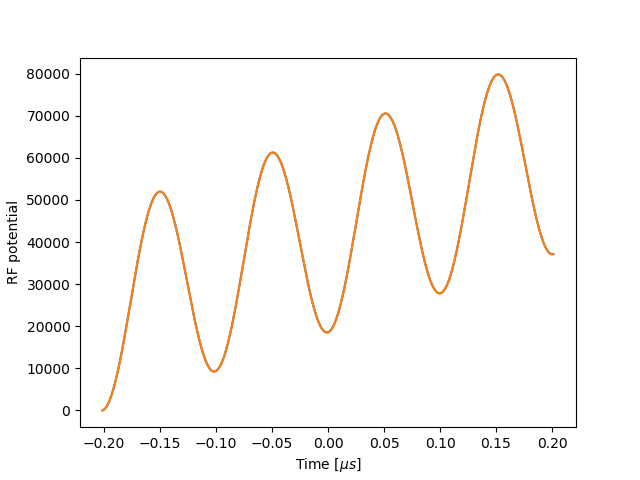

Text(0, 0.5, 'RF potential')

In [13]:
# Comparing the analytical rf potential with the integrated one, with acceleration

plt.figure('Potential well acc -2')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array_acc-np.min(rf_potential_array_acc))
plt.plot(time_array*1e6, rf_potential_array_cubic_acc-np.min(rf_potential_array_cubic_acc))
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

## 2. Find potential wells

In [14]:
# The potential wells can be obtained using find_potential_wells_cubic (cubic spline interpolation)
# This returns the maxima locations and values, the minima locations and values, as well as the
# highest inner maximum if an inner bucket is detected

from blond_common_fork.rf_functions.potential import find_potential_wells_cubic

(potwell_max_locs, potwell_max_vals,
 potwell_inner_max, potwell_min_locs,
 potwell_min_vals) = find_potential_wells_cubic(
    time_array, rf_potential_array, mest=200, verbose=False)

<IPython.core.display.Javascript object>


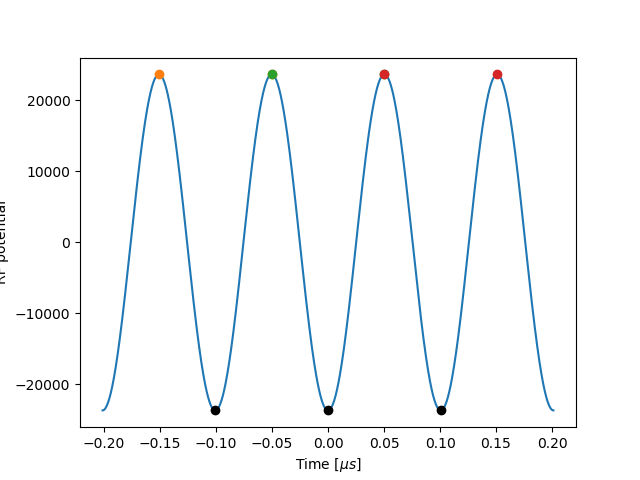

Text(0, 0.5, 'RF potential')

In [15]:
# Plotting the detected rf potential wells

plt.figure('Potential well -3')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array)
for index_pot in range(len(potwell_max_locs)):
    plt.plot(np.array(potwell_max_locs)[index_pot]*1e6,
             np.array(potwell_max_vals)[index_pot], 'o')
plt.plot(np.array(potwell_min_locs)*1e6, potwell_min_vals, 'ko')
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [16]:
# The same can be done for the accelerating case

from blond_common_fork.rf_functions.potential import find_potential_wells_cubic

(potwell_max_locs_acc, potwell_max_vals_acc,
 potwell_inner_max_acc, potwell_min_locs_acc,
 potwell_min_vals_acc) = find_potential_wells_cubic(
    time_array, rf_potential_array_acc, mest=200, verbose=False)

<IPython.core.display.Javascript object>


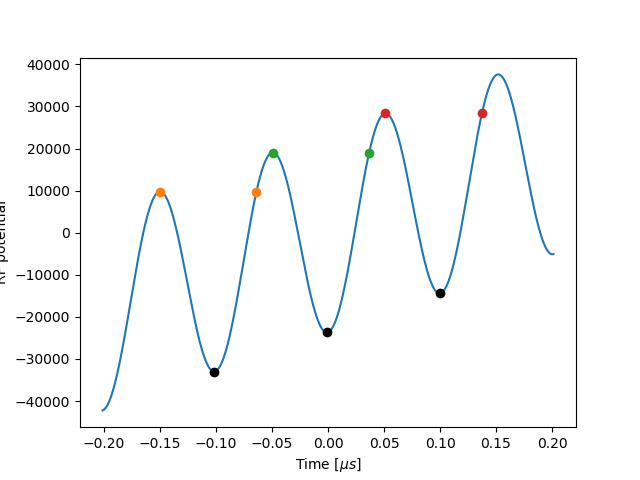

Text(0, 0.5, 'RF potential')

In [17]:
# Plotting the detected rf potential wells with acceleration

plt.figure('Potential well -4')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array_acc)
for index_pot in range(len(potwell_max_locs_acc)):
    plt.plot(np.array(potwell_max_locs_acc)[index_pot]*1e6,
             np.array(potwell_max_vals_acc)[index_pot], 'o')
plt.plot(np.array(potwell_min_locs_acc)*1e6, potwell_min_vals_acc, 'ko')
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

## 3. Cut potential wells to get separatrices, acceptance

In [18]:
# Once the potential wells are detected, the potential_well_cut can be used to return
# lists containing all the potential wells and their corresponding time array

from blond_common_fork.rf_functions.potential import potential_well_cut

time_array_list, potential_well_list = potential_well_cut(
    time_array, rf_potential_array_acc, potwell_max_locs_acc)


<IPython.core.display.Javascript object>


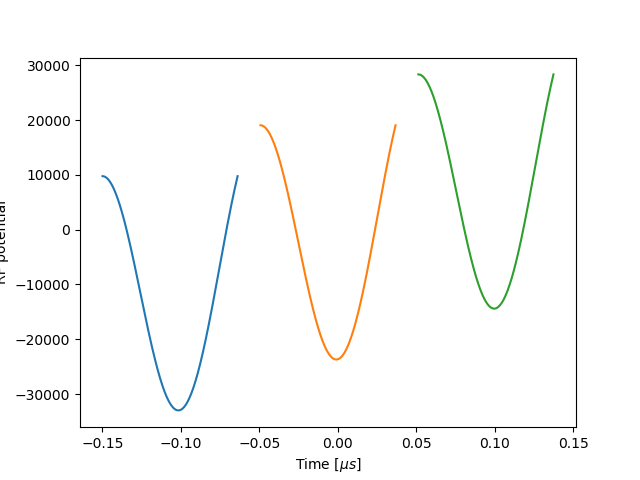

Text(0, 0.5, 'RF potential')

In [19]:
# Plotting the cut potential wells

plt.figure('Potential well cut')
plt.clf()
for index_pot in range(len(time_array_list)):
    plt.plot(time_array_list[index_pot]*1e6, potential_well_list[index_pot])
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [20]:
# The trajectory defined by the potential well (i.e. the separatrices) can be obtained with trajectory_area
# This also returns the enclosed area (i.e. the acceptance) and the half height in E of the trajectory

from blond_common_fork.rf_functions.potential import trajectory_area_cubic

eta_0 = ring.eta_0[0,0]
beta_rel = ring.beta[0,0]
tot_energy = ring.energy[0,0]

dEtraj_list = []  # The trajectories at the edge of the pot. well
calc_area_list = []  # The enclosed areas

for index_pot in range(len(time_array_list)):
    (time_array, dEtraj, hamiltonian, calc_area,
     half_energy_height, full_length_time) = trajectory_area_cubic(
        time_array_list[index_pot], potential_well_list[index_pot],
        eta_0, beta_rel, tot_energy)
    dEtraj_list.append(dEtraj)
    calc_area_list.append(calc_area)


C:\Work\git\blond_common_fork\rf_functions\potential.py:420: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


<IPython.core.display.Javascript object>


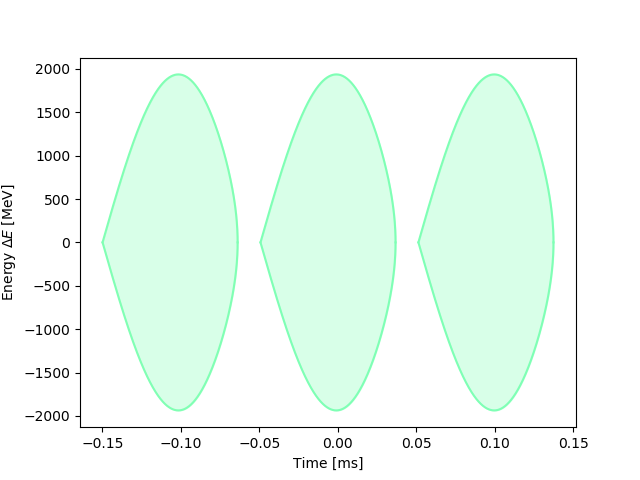

In [21]:
plt.figure('Separatrices')
plt.clf()
colors = plt.cm.rainbow(np.interp(calc_area_list,
                             [0.9*np.min(calc_area_list), 1.1*np.max(calc_area_list)],
                             [0, 1]))
for index_pot in range(len(time_array_list)):
    plt.plot(time_array_list[index_pot]*1e6, dEtraj_list[index_pot]/1e6, color=colors[index_pot])
    plt.plot(time_array_list[index_pot]*1e6, -dEtraj_list[index_pot]/1e6, color=colors[index_pot])
    plt.fill_between(time_array_list[index_pot]*1e6, dEtraj_list[index_pot]/1e6,
                     -dEtraj_list[index_pot]/1e6, color=colors[index_pot],
                     alpha=0.3)
    plt.xlabel('Time [ms]')
    plt.ylabel('Energy $\\Delta E$ [MeV]')

## 4. Get the action as a function of the hamiltonian

In [22]:
from blond_common_fork.rf_functions.potential import area_vs_hamiltonian_cubic

eta_0 = ring.eta_0[0,0]
beta_rel = ring.beta[0,0]
tot_energy = ring.energy[0,0]

index_pot = 1

(time_array_ham, hamiltonian_scan, \
    calc_area_scan, half_energy_height_scan, \
    full_length_time_scan) = area_vs_hamiltonian_cubic(
    time_array_list[index_pot], potential_well_list[index_pot],
    eta_0, beta_rel, tot_energy, n_points_reinterp=100,
    inner_max_potential_well=potwell_inner_max_acc[index_pot])

<IPython.core.display.Javascript object>


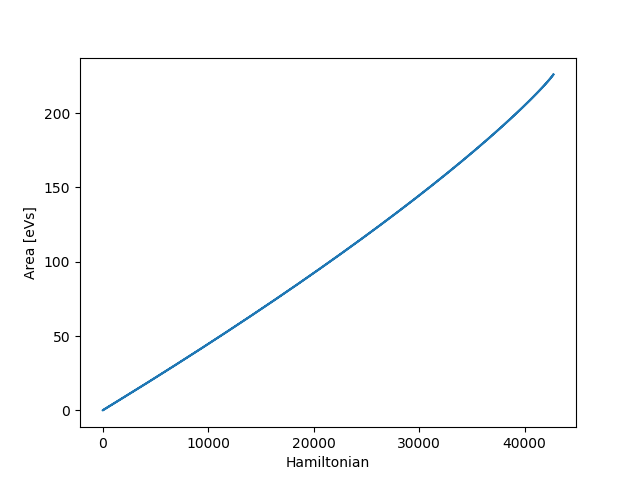

Text(0, 0.5, 'Area [eVs]')

In [23]:
plt.figure('Area vs. hamiltonian')
plt.plot(hamiltonian_scan[1:], calc_area_scan[1:])
plt.xlabel('Hamiltonian')
plt.ylabel('Area [eVs]')

## 5. Compute synchrotron frequency vs. amplitude

In [24]:
from blond_common_fork.rf_functions.potential import synchrotron_frequency_cubic
from blond_common_fork.maths.calculus import deriv_cubic

sort_hamiltonian = np.argsort(calc_area_scan)
fs_cubic_manual = deriv_cubic(calc_area_scan[sort_hamiltonian],
                       hamiltonian_scan[sort_hamiltonian])[1]/(2*np.pi)

(time_array_fs, fs_cubic, hamiltonian_scan,
 calc_area_scan, half_energy_height_scan,
 full_length_time_scan) = synchrotron_frequency_cubic(
    time_array_list[index_pot], potential_well_list[index_pot],
    eta_0, beta_rel, tot_energy, n_points_reinterp=100,
    inner_max_potential_well=potwell_inner_max_acc[index_pot])

<IPython.core.display.Javascript object>


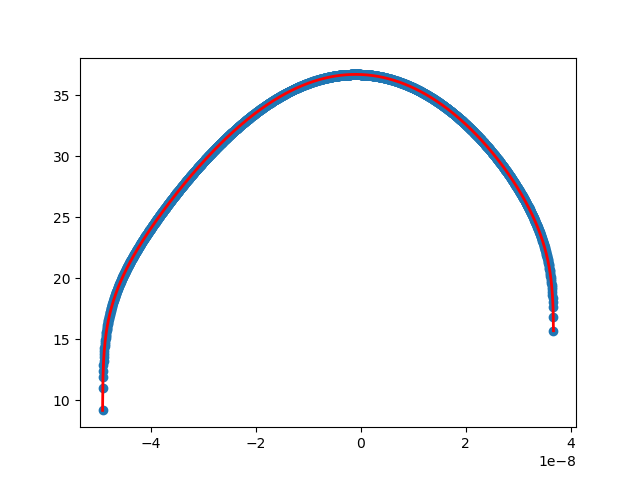

In [25]:
plt.figure('Sync freq')
plt.clf()
plt.plot(time_array_ham[sort_hamiltonian], fs_cubic_manual, 'o')
plt.plot(time_array_fs, fs_cubic, 'r', linewidth=2)